In [10]:
import statsmodels
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import hvplot.xarray
import pandas as pd
from tqdm import tqdm
import scipy
from scipy import signal

plt.rcParams.update({
    'text.usetex':True,
    'font.family':'serif',
    'font.size':18
})

import seaborn as sns
# set the theme
sns.set_palette('inferno', 3)

In [2]:
from statsmodels.tsa import seasonal

In [3]:
fn = '/datadrive/NCCFs/arrival_times/no_outlier_removal.nc'
arrival_times = xr.open_dataarray(fn)

## Look at changes due to depth

In [4]:
fn = '/datadrive/simulation/linear_arrivaltimechange_due2depth.nc'
depth_change = xr.open_dataarray(fn)

In [5]:
depth_change_201 = depth_change.rolling(time=201).mean().rename({'time':'dates'})
depth_change_601 = depth_change.rolling(time=601).mean().rename({'time':'dates'})
depth_change_1001 = depth_change.rolling(time=1001).mean().rename({'time':'dates'})

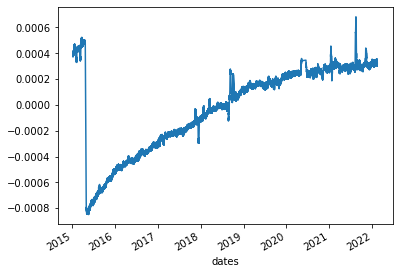

In [6]:
depth_change_201.plot()

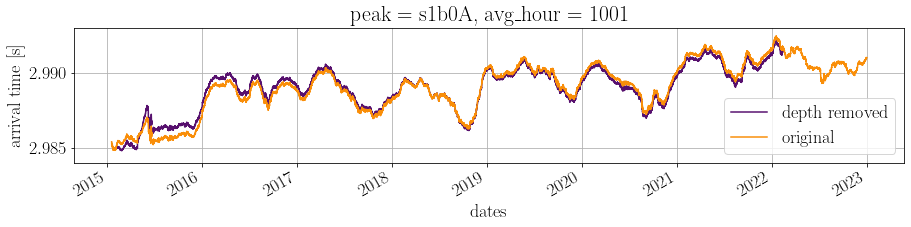

In [14]:
fig = plt.figure(figsize=(13,3.5))
((-1*arrival_times[4]) - depth_change_1001).plot(label='depth removed')
((-1*arrival_times[4])).plot(label='original', c='C2')
plt.ylim([2.984, 2.993])
plt.grid()
plt.legend()
plt.ylabel('arrival time [s]')

plt.tight_layout()
fig.savefig('figures/depth_adjusted.png', dpi=300)

## Time Series Decomposition

In [18]:
fn = '/datadrive/NCCFs/arrival_times/no_outlier_removal.nc'
da = xr.open_dataarray(fn)

In [19]:
# get id of first nan
nan_idx = np.argmin(np.isnan(da[4].values))
da_slice = da[4].interpolate_na(dim='dates')[nan_idx:]

Text(0, 0.5, 'arrival time')

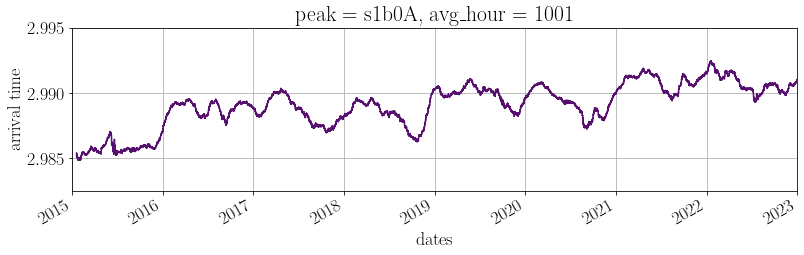

In [24]:
fig = plt.figure(figsize=(13,3))
(-1*da_slice).plot()
plt.xlim([pd.Timestamp('2015-01-01'), pd.Timestamp('2023-01-01')])
plt.grid()
plt.ylim([2.9825, 2.995])
plt.ylabel('arrival time')

In [29]:
period = int(356.25 * 24)
res_1year = seasonal.seasonal_decompose((-1*da_slice.values), period=period)

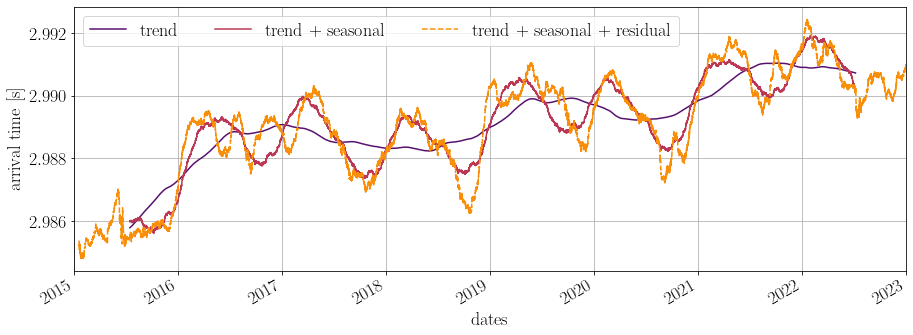

In [105]:
fig = plt.figure(figsize=(13,5))
#plt.plot(da_slice.dates, res_1year.resid + res_1year.trend,)
plt.plot(da_slice.dates, res_1year.trend, label='trend')
plt.plot(da_slice.dates, res_1year.trend + res_1year.seasonal, label='trend + seasonal')
plt.grid()
plt.xlim([pd.Timestamp('2015-01-01'), pd.Timestamp('2023-01-01')])

(-1*da_slice).plot(label='trend + seasonal + residual', linestyle='--')
plt.legend(ncol=3)
plt.title('')

plt.tight_layout()
plt.ylabel('arrival time [s]')
fig.savefig('figures/ts_decop_overlay.png', dpi=300)

In [107]:
xticks = [pd.Timestamp('2015-01-01'), 
          pd.Timestamp('2016-01-01'), 
          pd.Timestamp('2017-01-01'), 
          pd.Timestamp('2018-01-01'), 
          pd.Timestamp('2019-01-01'), 
          pd.Timestamp('2020-01-01'), 
          pd.Timestamp('2021-01-01'), 
          pd.Timestamp('2022-01-01'), 
]

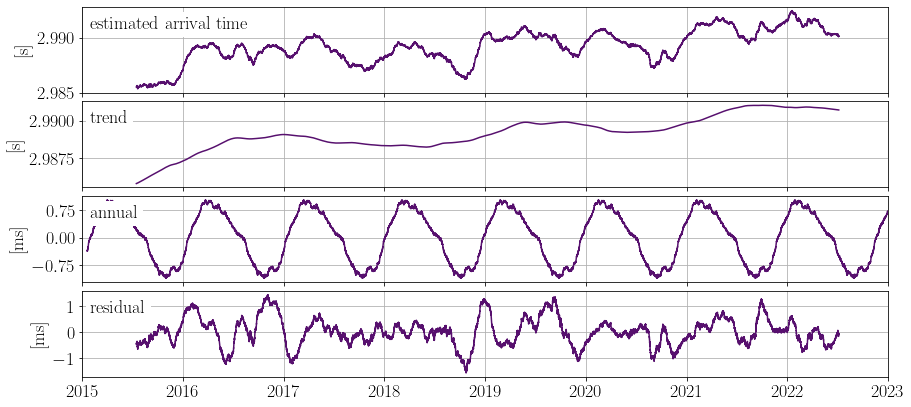

In [115]:
label_x = 0.01
label_y = 0.75

# Create a figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(13, 6))

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0)

plt.sca(axes[0])
plt.plot(da_slice.dates, res_1year.trend + res_1year.seasonal + res_1year.resid)
plt.grid()
plt.ylabel('[s]')
text_box_props = dict(facecolor='white', edgecolor='white')
plt.text(label_x,label_y,'estimated arrival time', transform=axes[0].transAxes, bbox=text_box_props)
plt.xlim([pd.Timestamp('2015-01-01'), pd.Timestamp('2023-01-01')])
axes[0].set_xticklabels('')

# Plot something in each subplot
plt.sca(axes[1])
axes[1].set_xticklabels('')
plt.plot(da_slice.dates, res_1year.trend)
plt.grid()
plt.ylabel('[s]')
text_box_props = dict(facecolor='white', edgecolor='white')
plt.text(label_x,label_y,'trend', transform=axes[1].transAxes, bbox=text_box_props)
plt.xlim([pd.Timestamp('2015-01-01'), pd.Timestamp('2023-01-01')])

plt.sca(axes[2])
axes[2].set_xticklabels('')
plt.plot(da_slice.dates, res_1year.seasonal*1000)
plt.grid()
plt.ylabel('[ms]')
axes[2].set_yticks([0.75,0,-0.75])
text_box_props = dict(facecolor='white', edgecolor='white')
plt.text(label_x,label_y,'annual', transform=axes[2].transAxes, bbox=text_box_props)
plt.xlim([pd.Timestamp('2015-01-01'), pd.Timestamp('2023-01-01')])


plt.sca(axes[3])
plt.plot(da_slice.dates, res_1year.resid*1000)
plt.grid()
plt.ylabel('[ms]')
text_box_props = dict(facecolor='white', edgecolor='white')
plt.text(label_x,label_y,'residual', transform=axes[3].transAxes, bbox=text_box_props)
plt.xlim([pd.Timestamp('2015-01-01'), pd.Timestamp('2023-01-01')])

plt.tight_layout()

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.1)

fig.savefig('figures/ts_decomp.png', dpi=300)

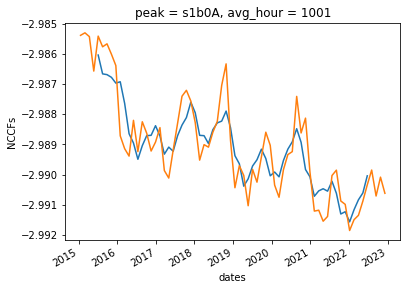

In [59]:
plt.plot(da_slice.dates, res_1year.trend + res_1year.seasonal)
da_slice.plot()

## Compute Spectrum

In [13]:
nan_idx = np.argmin(np.isnan(arrival_times.values[0,:]))
arrival_times_nonan = arrival_times.interpolate_na(dim='dates')[:,nan_idx:]
arrival_times_nm = arrival_times_nonan - arrival_times.mean('dates')

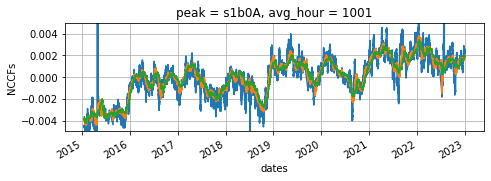

In [34]:
fig = plt.figure(figsize=(7.5, 2))
(-1*arrival_times_nm[0,:]).plot()
(-1*arrival_times_nm[2,:]).plot()
(-1*arrival_times_nm[4,:]).plot()
plt.ylim([-5e-3, 5e-3])
plt.grid()

In [39]:
Rxx = signal.fftconvolve(arrival_times_nm, np.flip(arrival_times_nm, axis=1), mode='full', axes=1)
arrival_times_f = scipy.fft.fft(np.hstack((Rxx, np.zeros((6,1000000)))), axis=1)
f = np.linspace(0,1,arrival_times_f.shape[1])

In [40]:
at_half = arrival_times_f[:, :int(arrival_times_f.shape[1]/2)]
f_half = f[:int(arrival_times_f.shape[1]/2)]
t_half = 1/f_half[1:]

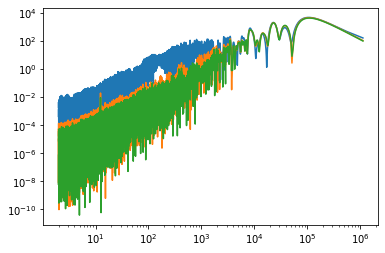

In [52]:
plt.plot(t_half, np.abs(at_half[0,1:]))
plt.plot(t_half, np.abs(at_half[2,1:]))
plt.plot(t_half, np.abs(at_half[4,1:]))
plt.xscale('log')
plt.yscale('log')

plt.xlim([

Text(0, 0.5, 'amplitude [s]')

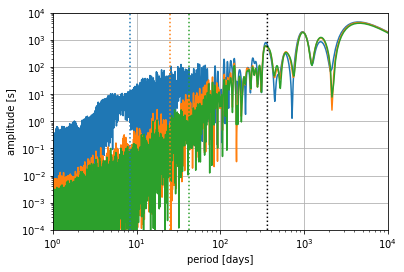

In [66]:
plt.plot(t_half/24, np.abs(at_half[0,1:]))
plt.plot(t_half/24, np.abs(at_half[2,1:]))
plt.plot(t_half/24, np.abs(at_half[4,1:]))

plt.xscale('log')
plt.yscale('log')

plt.xlim([1e0, 1e4])
plt.ylim([1e-4, 1e4])


plt.plot([365.25, 365.24], [1e-4, 1e4], 'k:')

plt.plot([201/24, 201/24], [1e-4, 1e4], 'C0:')
plt.plot([601/24, 601/24], [1e-4, 1e4], 'C1:')
plt.plot([1001/24, 1001/24], [1e-4, 1e4], 'C2:')

plt.grid()
plt.xlabel('period [days]')
plt.ylabel('amplitude [s]')

### ARCHIVE: Attempts with logarithmic dft

In [214]:
def logarithmic_dft(signal, start_f, end_f, npts, fs):
    N = len(signal)
    frequencies = np.logspace(np.log10(start_f/(fs/2)), np.log10(end_f/(fs/2)), npts)
    ldft = np.zeros(npts, dtype=np.complex128)
    
    for k in tqdm(range(npts)):
        omega = 2 * np.pi * frequencies[k] / N
        for n in range(N):
            ldft[k] += signal[n] * np.exp(-1j * omega * n)
    
    return ldft

In [217]:
s1b0A_201_f = logarithmic_dft(arrival_times_nm.values, 1e-10, 100, 256, 1)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:23<00:00, 11.09it/s]


In [210]:
s1b0A_201_f_lin = scipy.fft.fft(arrival_times_nm.values)

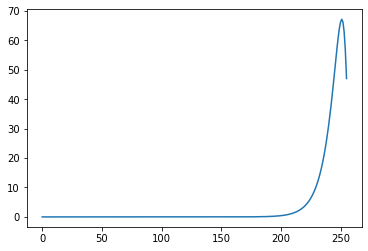

In [213]:
frequencies = np.logspace(np.log10(1e-10/(1/2)), np.log10(end_f/(fs/2)), npts)
plt.plot(np.abs(s1b0A_201_f))

In [84]:
mu = 1                     # Order mu of Bessel function
r = np.logspace(-10, 1, 2048)  # Input evaluation points
dln = np.log(r[1]/r[0])      # Step size
offset = scipy.fft.fhtoffset(dln, initial=-10*np.log(10), mu=mu)
k = np.exp(offset)/r[::-1]   # Output evaluation points

In [ ]:
s1b0A_201_f = scipy.fft.fht(arrival_times_nm.values, dln, mu=mu, offset=offset)

In [ ]:
s1b0A_201_f

array([-0.00479814, -0.00478426, -0.00473128, ..., -0.00475549,
       -0.00479312, -0.00478766])

In [66]:
np.log10(1e-10)

-10.0

#### Figure out how to use discrete hankel transform

In [194]:
t = np.arange(0,10,0.005)
x = np.sin(2*np.pi*30*t)

In [196]:
xf_lin = scipy.fft.fft(x)
f_lin = np.linspace(0,200,len(x))

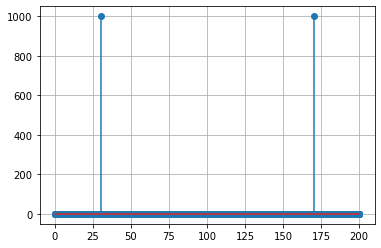

In [198]:
plt.stem(f_lin, np.abs(xf_lin))
plt.grid()

In [199]:
mu = 0.0                     # Order mu of Bessel function
r = np.logspace(-7, 1, 1024)  # Input evaluation points
dln = np.log(r[1]/r[0])      # Step size
offset = scipy.fft.fhtoffset(dln, initial=-6*np.log(10), mu=mu)
k = np.exp(offset)/r[::-1]   # Output evaluation points

In [200]:
xf_log = scipy.fft.fht(x, dln, mu=mu, offset=offset)

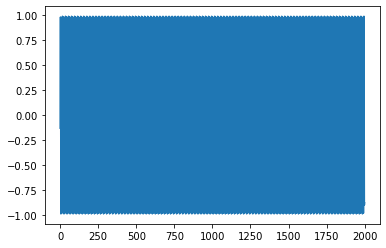

In [203]:
plt.plot(xf_log)